# FuncX Roundtrip Execution Time

The goal is to understand how ProxyStore can reduce FuncX task round trip time by avoiding data transfer through the cloud.

The takeaway is that execution time can be greatly improved with minimal code (2 lines: one to initialize ProxyStore and one to `proxy`).

Parameters:
- Client/Endpoint location: both ALCF, both NERSC, one in each
- Data size: 0 bytes to 100 MB
- Task type: no-op and sleep where proxy is async resolved
- PS backend

Notes:
- This experiment represents worst case scenario for ProxyStore+FuncX because tasks are executed serially so there is no overlapping of ProxyStore communication with waiting on FuncX tasks.

## Instructions

### Setup

Setup needs to be performed on all sites that will be used.

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a FuncX endpoint. Note that the endpoint configuration will need to be changed customized for the system, allocations, etc.
   ```bash
   $ funcx-endpoint configure psbench
   $ funcx-endpoint start psbench
   ```
   Endpoint config reference: https://funcx.readthedocs.io/en/latest/endpoints.html
3. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench --server {SIGNALING SERVER}
   $ proxystore-endpoint start psbench &> /dev/null &
   ```
   Note: endpoint logs will still be written to ~/.proxystore

### Run

```bash
$ python -m psbench.benchmarks.funcx_tasks \
    --funcx-endpoint {UUID} \  # UUID returned by funcx-endpoint start
    --task-repeat 5 \
    --task-sleep 0.0 \
    --input-sizes 100 1000 10000 \
    --output-sizes 0 \
    --ps-backend ENDPOINT --ps-endpoints {UUID} {UUID} \ # UUIDs for all ProxyStore endpoints
    --csv-file {OUTPUT-CSV-FILE}
```

### Notes

- All experiments done with Python 3.9
- proxystore-benchmark commit hash used: `bf643cd2dee85e243f92c824cd701ee02ac8ace5`
- When a job is needed for a worker, its best to run a small benchmark to allocate nodes then run the benchmark for real.
- Theta can be fussy about connecting to the websocket signaling server. I had to use `wss://{ip-address}:{port}` rather than `wss://{url}` as the server address in the endpoint config, but the connection will fail because the SSL certificate does not match the IP address. To get around this, modify `PeerManager.async_init()` in `proxystore/p2p/manager.py` to disable certificate verification.
  ```python
  async def async_init(self) -> None:
      if self._websocket_or_none is None:
          import ssl
          ssl_context = ssl.SSLContext()
          ssl_context.verify_mode = ssl.CERT_NONE
          uuid, _, socket = await connect(
              address=self._signaling_server,
              uuid=self._uuid,
              name=self._name,
              timeout=self._timeout,
              ssl=ssl_context,
          )
          ...
  ```

In [2]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy
import seaborn

# to change default colormap
plt.rcParams["image.cmap"] = "tab10"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.RdYlGn(numpy.linspace(0,1,5)))

In [3]:
BACKEND_COLUMN = 'proxystore_backend'
INPUT_SIZE_COLUMN = 'input_size_bytes'
TOTAL_TIME_COLUMN = 'total_time_ms'
SLEEP_COLUMN = 'task_sleep_seconds'

def load(filepath: str) -> pandas.DataFrame:
    df = pandas.read_csv(filepath)
    df[BACKEND_COLUMN] = df[BACKEND_COLUMN].fillna('FuncX')
    return df

In [4]:
theta_theta_noop_data = load('data/funcx-roundtrip/noop-thetalogin5-thetalogin5.csv')
theta_theta_sleep_data = load('data/funcx-roundtrip/sleep-thetalogin5-thetalogin5.csv')
perlmutter_perlmutter_noop_data = load('data/funcx-roundtrip/noop-perlmutterlogin24-perlmutter.csv')
perlmutter_perlmutter_sleep_data = load('data/funcx-roundtrip/sleep-perlmutterlogin24-perlmutter.csv')
midway_theta_noop_data = load('data/funcx-roundtrip/noop-midway2-thetalogin5.csv')
midway_theta_sleep_data = load('data/funcx-roundtrip/sleep-midway2-thetalogin5.csv')
frontera_theta_noop_data = load('data/funcx-roundtrip/noop-frontera-thetalogin5.csv')
frontera_theta_sleep_data = load('data/funcx-roundtrip/sleep-frontera-thetalogin5.csv')
theta_theta_noop_data.head()

,proxystore_backend,task_name,input_size_bytes,output_size_bytes,task_sleep_seconds,total_time_ms,input_get_ms,input_set_ms,input_proxy_ms,input_resolve_ms,output_get_ms,output_set_ms,output_proxy_ms,output_resolve_ms
0,RedisStore,pong,0,0,0.0,4650.879811,0.799879,0.612697,0.672251,1.309021,0.456481,0.181370,0.218129,0.496223
1,RedisStore,pong,0,0,0.0,524.804870,0.171808,0.159284,0.187025,0.286456,0.519274,0.111677,0.132690,0.553022
2,RedisStore,pong,0,0,0.0,441.614596,0.322965,0.247681,0.293021,0.552539,0.496648,0.223583,0.267020,0.520383
3,RedisStore,pong,0,0,0.0,444.925437,0.186252,0.222908,0.259728,0.372113,0.170443,0.314987,0.346212,0.184390
4,RedisStore,pong,0,0,0.0,473.428714,0.340134,0.142093,0.163705,0.598032,0.619038,0.250551,0.295044,0.650576


In [5]:
def get_backends(data: pandas.DataFrame) -> list[str]:
    return data[BACKEND_COLUMN].unique()

def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_input_sizes(data: pandas.DataFrame) -> list[int]:
    return list(data[INPUT_SIZE_COLUMN].unique())

def get_avg_total_time(data: pandas.DataFrame) -> float:
    """Drops min/max and takes average of remaining times."""
    times = list(data[TOTAL_TIME_COLUMN])
    if len(times) < 3:
        raise ValueError('Cannot drop min/max value when row count < 3')
    times.remove(min(times))
    times.remove(max(times))
    return sum(times) / len(times)

def extract_avg_times(data: pandas.DataFrame) -> dict[str, list[str]]:
    # Input dataframe should just contain one backend type
    assert len(get_backends(data)) == 1
    input_sizes = get_input_sizes(data)
    input_sizes
    avg_times = [
        get_avg_total_time(rows_matching_column_value(data, INPUT_SIZE_COLUMN, input_size)) for input_size in input_sizes
    ]
    # Convert to seconds
    avg_times = [x / 1000 for x in avg_times]
    return {'sizes': input_sizes, 'times': avg_times}

def extract(data: pandas.DataFrame) -> dict[str, dict[str, list[str]]]:
    result = {}
    for backend in get_backends(data):
        subset = rows_matching_column_value(data, BACKEND_COLUMN, backend)
        result[backend] = extract_avg_times(subset)
    return result

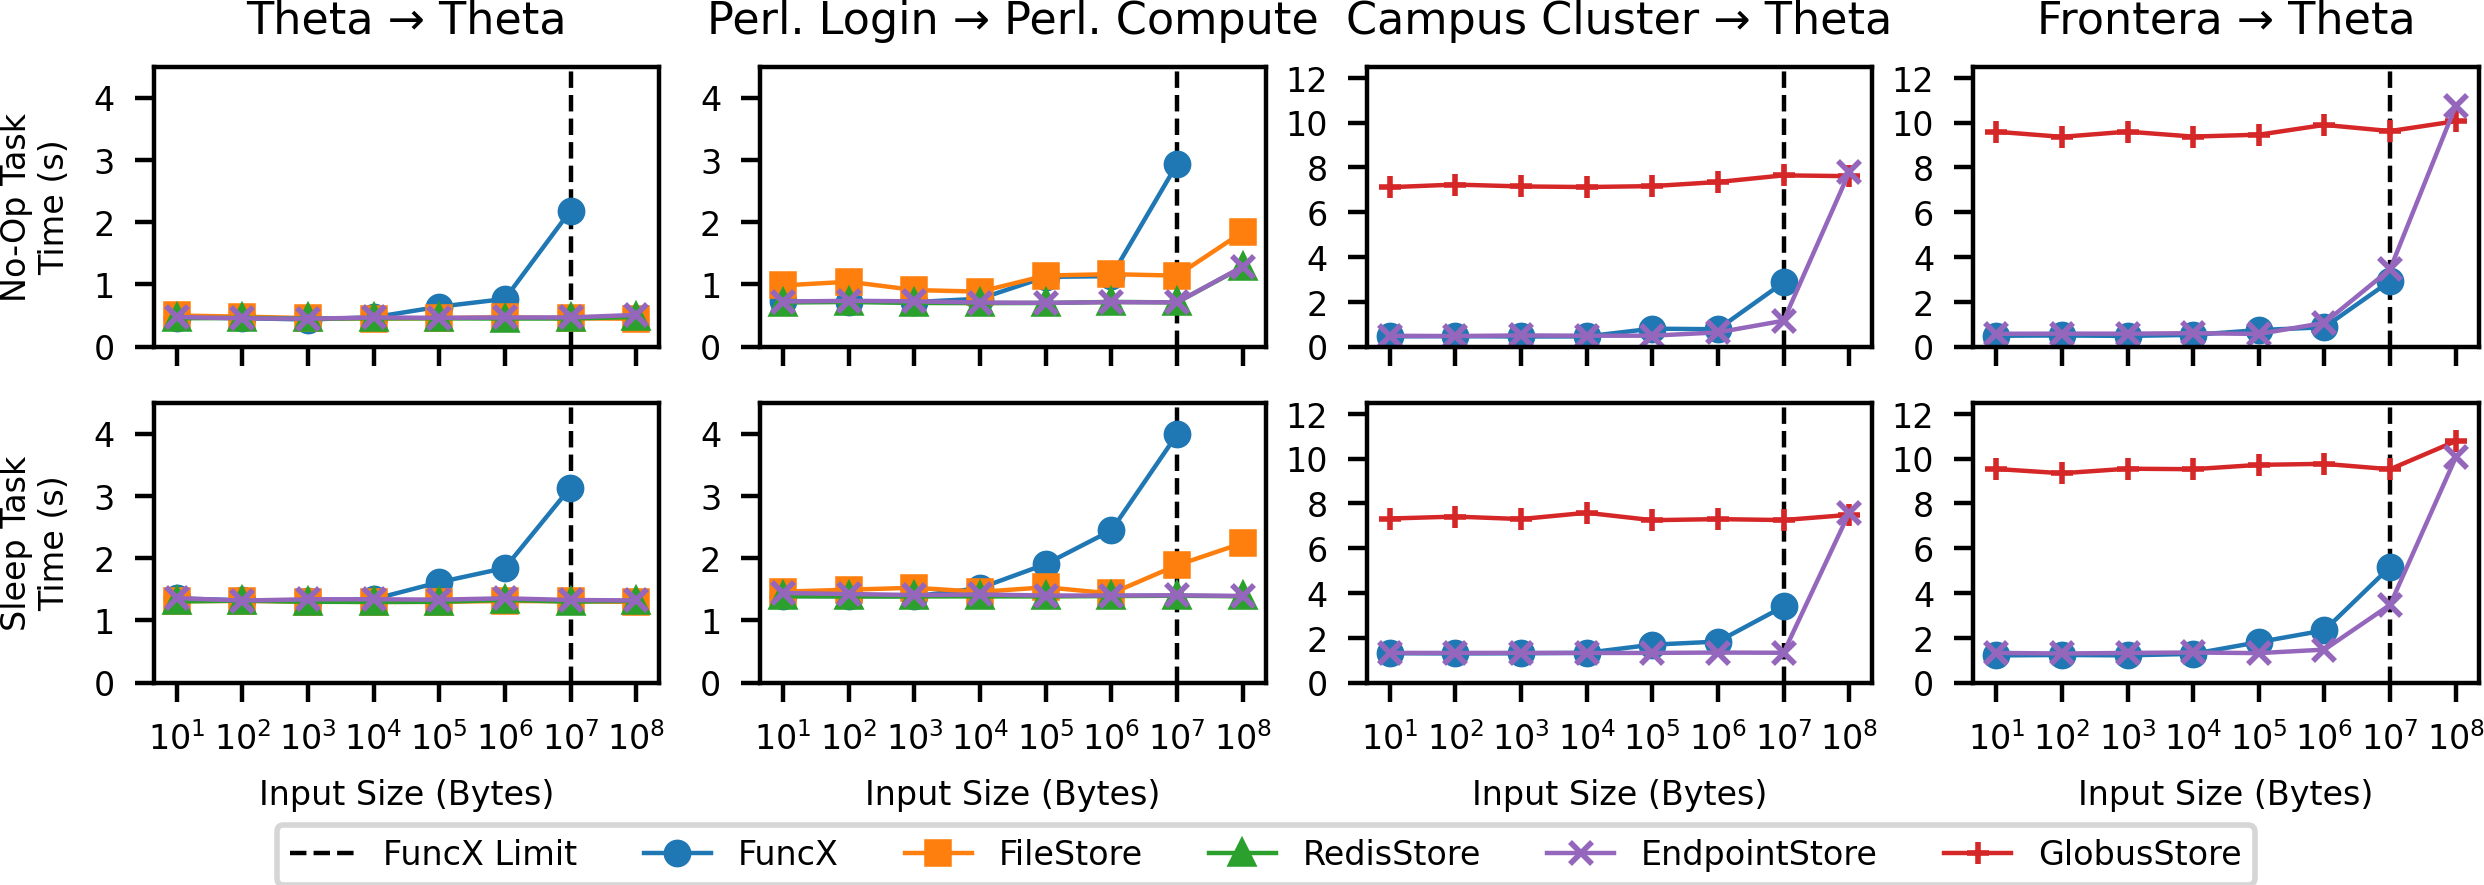

In [9]:
extracted_data = [
    [
        extract(theta_theta_noop_data),
        extract(perlmutter_perlmutter_noop_data),
        extract(midway_theta_noop_data),
        extract(frontera_theta_noop_data),
    ],
    [
        extract(theta_theta_sleep_data), 
        extract(perlmutter_perlmutter_sleep_data), 
        extract(midway_theta_sleep_data),
        extract(frontera_theta_sleep_data),
    ],
]

backends = ['FuncX', 'FileStore', 'RedisStore', 'GlobusStore', 'EndpointStore']

rows = 2
cols = 4

fig, axs = plt.subplots(rows, cols, sharex=True) # , sharey='row')

cmap = plt.get_cmap()
colors = {backend: cmap(i) for i, backend in enumerate(backends)}
# markers_ = {backend: markers.MarkerStyle.filled_markers[i] for i, backend in enumerate(backends)}
markers_ = {backend: ('o', 's', '^', '+', 'x', 'P')[i] for i, backend in enumerate(backends)}
legend_handles = {}  # backend (str): axs handle


for i in range(rows):
    for j in range(cols):
        ax = axs[i, j]
        ax.axvline(1e7, color='black', linestyle='--', label='FuncX Limit')

        data = extracted_data[i][j]
        for backend in backends:
            if backend in data:
                xy = [(x, y) for x, y in zip(data[backend]['sizes'], data[backend]['times']) if 0 < x < 1e9]
                x, y  = zip(*xy)
                ax.plot(x, y, marker=markers_[backend], label=backend, color=colors[backend])

        # ax.set_yscale('log')
        ax.set_xscale('symlog')
        ax.set_xticks([10 ** x for x in range(1, 9)])
        
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            if label not in legend_handles:
                legend_handles[label] = handle

# plt.suptitle('FuncX Task Round Trip Times (s)')

axs[1, 0].set_xlabel('Input Size (Bytes)', fontsize=6)
axs[1, 1].set_xlabel('Input Size (Bytes)', fontsize=6)
axs[1, 2].set_xlabel('Input Size (Bytes)', fontsize=6)
axs[1, 3].set_xlabel('Input Size (Bytes)', fontsize=6)
axs[0, 0].set_ylabel('No-Op Task\nTime (s)', fontsize=6)
axs[1, 0].set_ylabel('Sleep Task\nTime (s)', fontsize=6)
axs[0, 0].set_title('Theta → Theta')
axs[0, 1].set_title('Perl. Login → Perl. Compute')
axs[0, 2].set_title('Campus Cluster → Theta')
axs[0, 3].set_title('Frontera → Theta')

# Reorder legend
# handles, labels = axs[0, 0].get_legend_handles_labels()
# legend_order = [1, 2, 3, 4, 0]
# axs[0, 0].legend([handles[i] for i in legend_order], [labels[i] for i in legend_order], loc='upper left')
# axs[0, 0].legend(legend_handles.values(), legend_handles.keys(), loc='upper left')
axs[1, 0].legend(legend_handles.values(), legend_handles.keys(), loc='upper center', bbox_to_anchor=(2.2, -0.45), ncol=6)

# Restrict y axis range
for yi in (0, 1):
    for xi in (0, 1, 2, 3):
        axs[yi, xi].set_ylim([0, 4.5 if xi < 2 else 12.5])
        axs[yi, xi].set_ylim([0, 4.5 if xi < 2 else 12.5])

# Restrict y labels to integers
for yi in (0, 1):
    for xi in (0, 1, 2, 3):
        axs[yi, xi].get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))

# fig.tight_layout(h_pad=0.5, w_pad=0.5)

fig.set_size_inches(7.5, 2)
plt.savefig('figures/funcx-roundtrip-task-times.png', pad_inches=0.05)